# Loading data

In [4]:
from RecSys_Course_AT_PoliMi.load_data import *
URM = load.load_urm()
ICM = load.load_icm(False)
URM_train_validation,URM_train,URM_validation,URM_test = load.train_valid_test_split(load.load_urm())
URM = sps.csr_matrix((URM.interaction,(URM.userID,URM.itemID)))
data_target_users_test = load.target()

In [5]:
cd RecSys_Course_AT_PoliMi/

C:\Users\utente\Desktop\RecSys_Course_AT_PoliMi


In [6]:
from RecSys_Course_AT_PoliMi.Recommenders import *
import os, multiprocessing
from functools import partial

In [7]:
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.Recommender_utils import check_matrix
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

from HyperparameterTuning.run_hyperparameter_search import *

n_cases=150
cutoff=10

EvaluatorHoldout: Ignoring 13614 ( 0.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13618 ( 0.2%) Users that have less than 1 test interactions


C:\Users\utente\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [8]:
stacked_URM_train = sps.vstack([URM_train, 1.5*ICM.T])
stacked_URM_train = sps.csr_matrix(stacked_URM_train)

stacked_URM_train_validation = sps.vstack([URM_train, 1.5*ICM.T])
stacked_URM_train_validation = sps.csr_matrix(stacked_URM_train_validation)

In [7]:
from Recommenders.BaseSimilarityMatrixRecommender import *
class new_hybridization(BaseRecommender):
    def __init__(self, URM,recommender0,recommender1,recommender2,recommender3,recommender4,recommender5,
                  exclude_seen=True,norm_scores=True):  # K=2000 in K_cross long

        super().__init__(URM, exclude_seen)
        self.URM=URM
        self.norm_scores=norm_scores
        self.normalize = None
        self.weights = {}
        self.weight_vec = None
        self.ratings = None
        self.rating_masks = None
        self.recommender0 = recommender0
        self.recommender1 = recommender1
        self.recommender2 = recommender2
        self.recommender3 = recommender3
        self.recommender4 = recommender4
        self.recommender5 = recommender5
        self.low_data_rec_idxs = None
        self.threshold = 3

    def fit(self,new_top_pop=0,new_user_knn_cf=0,UCF_cold=0,IALS_cold=0,EASE_R_cold=0,SLIM_elastic_net_cold=0,
            UCF_mid=0,IALS_mid=0,EASE_R_mid=0,SLIM_elastic_net_mid=0,
            EASE_R_warm=0,SLIM_elastic_net_warm=0,UCF_warm=0,IALS_warm=0,RP3beta_warm=0,
            normalize=True, threshold=0):
        self.w0new= new_top_pop
        self.w1new= new_user_knn_cf
        
        self.w1cold= UCF_cold
        self.w2cold= IALS_cold
        self.w4cold= EASE_R_cold
        self.w5cold= SLIM_elastic_net_cold
        
        self.w1mid= UCF_mid
        self.w2mid= IALS_mid
        self.w4mid= EASE_R_mid
        self.w5mid= SLIM_elastic_net_mid
        
        self.w1warm= UCF_warm
        self.w2warm= IALS_warm
        self.w3warm= RP3beta_warm
        self.w4warm= EASE_R_warm
        self.w5warm= SLIM_elastic_net_warm
        self.normalize=normalize        
    
    def _compute_item_score(self, user_id_array, items_to_compute=None):
        item_scores0 = self.recommender0._compute_item_score(user_id_array, items_to_compute)           
        item_scores1 = self.recommender1._compute_item_score(user_id_array, items_to_compute)
        item_scores2 = self.recommender2._compute_item_score(user_id_array, items_to_compute)
        item_scores3 = self.recommender3._compute_item_score(user_id_array, items_to_compute)
        item_scores4 = self.recommender4._compute_item_score(user_id_array, items_to_compute)
        item_scores5 = self.recommender5._compute_item_score(user_id_array, items_to_compute)
        
        if self.normalize:
            mean0 = np.mean(item_scores0)
            mean1 = np.mean(item_scores1)
            mean2 = np.mean(item_scores2)
            mean3 = np.mean(item_scores3)
            mean4 = np.mean(item_scores4)
            mean5 = np.mean(item_scores5)
            std0 = np.std(item_scores0)
            std1 = np.std(item_scores1)
            std2 = np.std(item_scores2)
            std3 = np.std(item_scores3)
            std4 = np.std(item_scores4)
            std5 = np.std(item_scores5)
            item_scores0 = (item_scores0 - mean0) / std0
            item_scores1 = (item_scores1 - mean1) / std1
            item_scores2 = (item_scores2 - mean2) / std2
            item_scores3 = (item_scores3 - mean3) / std3
            item_scores4 = (item_scores4 - mean4) / std4
            item_scores5 = (item_scores5 - mean5) / std5
        
        
        item_scores = (item_scores0 * self.w0) +(item_scores1 * self.w1) + (item_scores2 * self.w2) 
        + (item_scores3 * self.w3) + (item_scores4 * self.w4) + (item_scores5 * self.w5) 
        
        return item_scores
    
    def recommend(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        recommendations=[]
        for user_id in user_id_array:
        #user_id=user_id_array
            relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
        #userknn + top_pop
            if len(relevant_items)<17:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs0 = self.recommender0.recommend(user_id)[:10]
                recs1 = self.recommender1.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs0[i],(10-i)*self.w0new])
                    borda_rank.append([recs1[i],(10-i)*self.w1new])

                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs))
            #slim + ease_R + userknn  +  ials
            elif len(relevant_items)<179:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs0 = self.recommender1.recommend(user_id)[:10]
                recs1 = self.recommender2.recommend(user_id)[:10]
                recs2 = self.recommender4.recommend(user_id)[:10]
                recs3 = self.recommender5.recommend(user_id)[:10]
                for i in range(0,10):
                    borda_rank.append([recs0[i],(10-i)*self.w1cold])
                    borda_rank.append([recs1[i],(10-i)*self.w2cold])
                    borda_rank.append([recs2[i],(10-i)*self.w4cold])
                    borda_rank.append([recs3[i],(10-i)*self.w5cold])
                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs))
            
            #slim + ease_R + userknn  +  ials
            elif len(relevant_items)<563:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs0 = self.recommender1.recommend(user_id)[:10]
                recs1 = self.recommender2.recommend(user_id)[:10]
                recs2 = self.recommender4.recommend(user_id)[:10]
                recs3 = self.recommender5.recommend(user_id)[:10]
                for i in range(0,10):
                    borda_rank.append([recs0[i],(10-i)*self.w1mid])
                    borda_rank.append([recs1[i],(10-i)*self.w2mid])
                    borda_rank.append([recs2[i],(10-i)*self.w4mid])
                    borda_rank.append([recs3[i],(10-i)*self.w5mid])
                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs))

             #slim + ease_R + userknn  +  ials + rp3beta
            else:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs0 = self.recommender1.recommend(user_id)[:10]
                recs1 = self.recommender2.recommend(user_id)[:10]
                recs2 = self.recommender3.recommend(user_id)[:10]
                recs3 = self.recommender4.recommend(user_id)[:10]
                recs4 = self.recommender5.recommend(user_id)[:10]
                for i in range(0,10):
                    borda_rank.append([recs0[i],(10-i)*self.w1warm])
                    borda_rank.append([recs1[i],(10-i)*self.w2warm])
                    borda_rank.append([recs2[i],(10-i)*self.w3warm])
                    borda_rank.append([recs3[i],(10-i)*self.w4warm])
                    borda_rank.append([recs4[i],(10-i)*self.w5warm])
                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs))
        #return recs
        return recommendations,None
    
    def recommend_sub(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        recommendations=[]
       
        user_id=user_id_array
        relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
    #userknn + top_pop
        recs=[]
        if len(relevant_items)<17:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs0 = self.recommender0.recommend(user_id)[:10]
            recs1 = self.recommender1.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs0[i],(10-i)*self.w0new])
                borda_rank.append([recs1[i],(10-i)*self.w1new])

            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            recommendations.append(list(recs))

        #slim + ease_R + userknn  +  ials
        elif len(relevant_items)<179:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs0 = self.recommender1.recommend(user_id)[:10]
            recs1 = self.recommender2.recommend(user_id)[:10]
            recs2 = self.recommender4.recommend(user_id)[:10]
            recs3 = self.recommender5.recommend(user_id)[:10]
            for i in range(0,10):
                borda_rank.append([recs0[i],(10-i)*self.w1cold])
                borda_rank.append([recs1[i],(10-i)*self.w2cold])
                borda_rank.append([recs2[i],(10-i)*self.w4cold])
                borda_rank.append([recs3[i],(10-i)*self.w5cold])
            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            recommendations.append(list(recs))

        #slim + ease_R + userknn  +  ials
        elif len(relevant_items)<563:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs0 = self.recommender1.recommend(user_id)[:10]
            recs1 = self.recommender2.recommend(user_id)[:10]
            recs2 = self.recommender4.recommend(user_id)[:10]
            recs3 = self.recommender5.recommend(user_id)[:10]
            for i in range(0,10):
                borda_rank.append([recs0[i],(10-i)*self.w1mid])
                borda_rank.append([recs1[i],(10-i)*self.w2mid])
                borda_rank.append([recs2[i],(10-i)*self.w4mid])
                borda_rank.append([recs3[i],(10-i)*self.w5mid])
            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            recommendations.append(list(recs))

         #slim + ease_R + userknn  +  ials + rp3beta
        else:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs0 = self.recommender1.recommend(user_id)[:10]
            recs1 = self.recommender2.recommend(user_id)[:10]
            recs2 = self.recommender3.recommend(user_id)[:10]
            recs3 = self.recommender4.recommend(user_id)[:10]
            recs4 = self.recommender5.recommend(user_id)[:10]
            for i in range(0,10):
                borda_rank.append([recs0[i],(10-i)*self.w1warm])
                borda_rank.append([recs1[i],(10-i)*self.w2warm])
                borda_rank.append([recs2[i],(10-i)*self.w3warm])
                borda_rank.append([recs3[i],(10-i)*self.w4warm])
                borda_rank.append([recs4[i],(10-i)*self.w5warm])
            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            recommendations.append(list(recs))
        return recs

        return recommendations[:10]

In [92]:
from skopt.space import Real, Integer, Categorical 
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Hybrids.ScoresHybrid3Recommender import *
hyperparameters_range_dictionary = {
    'topK':Integer(1, 1000),
    'shrink':Real(1, 250),
    'normalize':Categorical([True,False]),
    'similarity':Categorical(["cosine", "jaccard", "asymmetric", "dice", "tversky", "tanimoto"]),
    'feature_weighting':Categorical(["none", "TF-IDF", "BM25"]),
    'stacked':Categorical([True]),
    'alpha':Real(1, 10),
}

In [10]:
userKNNCF = UserKNNCFRecommender(URM_train)
userKNNCF.fit(topK=963,shrink=354,similarity='cosine',normalize=True,feature_weighting='TF-IDF',stacked=False)

stackeduserKNNCF = UserKNNCFRecommender(URM_train,ICM)
stackeduserKNNCF.fit(topK= 421, shrink= 92.71432078633666, normalize= False, similarity ='jaccard', 
                         feature_weighting ='TF-IDF', stacked =True, alpha= 7.470823573622052)

RP3beta = RP3betaRecommender(URM_train)
RP3beta.fit(topK=140,alpha=1.233866449577629,beta=0.41668479920084195,normalize_similarity=True,implicit=True)

IALSrecommender = IALSRecommender(URM_train)
IALSrecommender.fit(num_factors= 49, epochs= 21, confidence_scaling= 'linear', alpha= 0.5270781908191616, 
                        epsilon=0.2666662068378747, reg= 8.455835190344516e-05)

SLIM_elastic_net = SLIMElasticNetRecommender(URM_train)
SLIM_elastic_net.fit(topK= 658, alpha= 0.000402457675051289, l1_ratio= 0.8040539242036574)

EASE_R = EASE_R_Recommender(URM_train, ICM)
EASE_R.fit(topK=None, l2_norm = 6849.353601137822, normalize_matrix = False,alpha= 15.834009463721085, stacked= True)

top_pop = TopPop(URM_train)
top_pop.fit()

userKNNCFv = UserKNNCFRecommender(URM_train_validation)
userKNNCFv.fit(topK=963,shrink=354,similarity='cosine',normalize=True,feature_weighting='TF-IDF',stacked=False)

stackeduserKNNCFv = UserKNNCFRecommender(URM_train_validation,ICM)
stackeduserKNNCFv.fit(topK= 421, shrink= 92.71432078633666, normalize= False, similarity ='jaccard', 
                         feature_weighting ='TF-IDF', stacked =True, alpha= 7.470823573622052)

RP3betav = RP3betaRecommender(URM_train_validation)
RP3betav.fit(topK=140,alpha=1.233866449577629,beta=0.41668479920084195,normalize_similarity=True,implicit=True)

IALSrecommenderv = IALSRecommender(URM_train_validation)
IALSrecommenderv.fit(num_factors= 49, epochs= 21, confidence_scaling= 'linear', alpha= 0.5270781908191616, 
                        epsilon=0.2666662068378747, reg= 8.455835190344516e-05)

SLIM_elastic_netv = SLIMElasticNetRecommender(URM_train_validation)
SLIM_elastic_netv.fit(topK= 658, alpha= 0.000402457675051289, l1_ratio= 0.8040539242036574)

EASE_Rv = EASE_R_Recommender(URM_train_validation, ICM)
EASE_Rv.fit(topK=None, l2_norm = 6849.353601137822, normalize_matrix = False,alpha= 15.834009463721085, stacked= True)

top_popv = TopPop(URM_train_validation)
top_popv.fit()

Similarity column 13650 (100.0%), 715.70 column/sec. Elapsed time 19.07 sec
Similarity column 13996 (100.0%), 777.46 column/sec. Elapsed time 18.00 sec
IALSRecommender: Epoch 1 of 21. Elapsed time 3.01 sec
IALSRecommender: Epoch 2 of 21. Elapsed time 5.89 sec
IALSRecommender: Epoch 3 of 21. Elapsed time 8.99 sec
IALSRecommender: Epoch 4 of 21. Elapsed time 12.02 sec
IALSRecommender: Epoch 5 of 21. Elapsed time 15.05 sec
IALSRecommender: Epoch 6 of 21. Elapsed time 18.08 sec
IALSRecommender: Epoch 7 of 21. Elapsed time 21.11 sec
IALSRecommender: Epoch 8 of 21. Elapsed time 24.35 sec
IALSRecommender: Epoch 9 of 21. Elapsed time 27.49 sec
IALSRecommender: Epoch 10 of 21. Elapsed time 30.54 sec
IALSRecommender: Epoch 11 of 21. Elapsed time 33.64 sec
IALSRecommender: Epoch 12 of 21. Elapsed time 36.73 sec
IALSRecommender: Epoch 13 of 21. Elapsed time 39.83 sec
IALSRecommender: Epoch 14 of 21. Elapsed time 43.13 sec
IALSRecommender: Epoch 15 of 21. Elapsed time 46.55 sec
IALSRecommender: Epo

In [17]:
from skopt.space import Real, Integer, Categorical 
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Hybrids.ScoresHybrid3Recommender import *
hyperparameters_range_dictionary = {
    "w1":Real(0,10),
    "w2":Real(0,10),
    "w3":Real(0,10),
    "w4":Real(0,10),
    "w1cold":Real(0,10),
    "w2cold":Real(0,10),
    "w3cold":Real(0,10),
    "w4cold":Real(0,10),
    "w1mid":Real(0,10),
    "w2mid":Real(0,10),
    "w3mid":Real(0,10),
    "w4mid":Real(0,10),
    "w5cold":Real(0,10),
    "w5mid":Real(0,10),
    "w5":Real(0,10),
    
}  

In [18]:
evaluator_validation = EvaluatorHoldout(URMs_test[0], cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URMs_test[1], cutoff_list=[10])
top_pop0 = TopPop(URMs_train[0])
top_pop0.fit()
top_pop1 = TopPop(URMs_train[1])
top_pop1.fit()

NameError: name 'URMs_test' is not defined

In [21]:

hyperparameterSearch = SearchBayesianSkopt(best,
                                         evaluator_validation=evaluator_validation,
                                         evaluator_test=evaluator_test)

In [22]:
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
  
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train,top_pop,userKNNCF,stackeduserKNNCF,IALSrecommender,
                                   EASE_R,SLIM_elastic_net,RP3beta],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)

In [26]:
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train_validation,top_popv,userKNNCFv,stackeduserKNNCFv,IALSrecommenderv,
                                   EASE_Rv,SLIM_elastic_netv,RP3betav],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)

In [27]:
import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 250  
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

In [ ]:
hyperparameterSearch.search(recommender_input_args,
                       recommender_input_args_last_test = recommender_input_args_last_test,
                       hyperparameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = n_random_starts,
                       save_model = "last",
                       output_folder_path = output_folder_path, # Where to save the results
                       output_file_name_root = "best no kfold", # How to call the files
                       metric_to_optimize = metric_to_optimize,
                       cutoff_to_optimize = cutoff_to_optimize,
                       resume_from_saved=True
                      )

In [ ]:
 {'w1': 0.013059189410321583, 'w2': 1.2478683164136475, 'w3': 3.8459515717040627, 'w4': 0.9593742978140043, 'w1cold': 7.371168409713473, 'w2cold': 9.743528125842841, 'w3cold': 5.489873036691385, 'w4cold': 0.15734772150403645, 'w1mid': 3.4160881151114, 'w2mid': 0.04709488511906224, 'w3mid': 9.221832671850352, 'w4mid': 9.49397791936225, 'w5cold': 9.09492719811822, 'w5mid': 3.2934610527054557, 'w5': 9.486624813452256}

In [32]:
stackeduserKNNCFs=[]
for i in range(5):
    stackeduserKNNCF = UserKNNCFRecommender(URMs_train[i],ICM)
    stackeduserKNNCF.fit(topK= 421, shrink= 92.71432078633666, normalize= False, similarity ='jaccard', 
                         feature_weighting ='TF-IDF', stacked =True, alpha= 7.470823573622052)
    stackeduserKNNCFs.append(stackeduserKNNCF)

Similarity column 13996 (100.0%), 779.14 column/sec. Elapsed time 17.96 sec
Similarity column 13996 (100.0%), 743.90 column/sec. Elapsed time 18.81 sec
Similarity column 13996 (100.0%), 761.17 column/sec. Elapsed time 18.39 sec
Similarity column 13996 (100.0%), 790.40 column/sec. Elapsed time 17.71 sec
Similarity column 13996 (100.0%), 816.55 column/sec. Elapsed time 17.14 sec


In [119]:
for i in range(5):
    final_rec = best(URMs_train[i],top_pops[i],userKNNCFs[i],stackeduserKNNCFs[i],IALSrecommenders[i],
                                   EASE_Rs[i],SLIM_elastic_nets[i])
    final_rec.fit(w1= 1.5990064734053968, w2= 0.6748196218391801, w3= 3.5520055696782658, w4= 2.565222120722938, 
     w1cold= 4.610361862254901, w2cold= 3.1857140108702744, w3cold= 1.8410711425507755, w4cold= 7.951271133985781, 
     w1mid= 0.7769345987358156, w2mid= 0.5744832112927918, w3mid= 3.445907364652354, w4mid= 3.7631372828929885)
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(final_rec)
    print(result.MAP)

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13646 (100.0%) in 3.40 min. Users per second: 67
cutoff
10    0.25071
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13645 (100.0%) in 3.31 min. Users per second: 69
cutoff
10    0.250195
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13641 (100.0%) in 3.43 min. Users per second: 66
cutoff
10    0.249646
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13643 (100.0%) in 3.19 min. Users per second: 71
cutoff
10    0.249638
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13642 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13642 (100.0%) in 3.26 min. Users per seco

In [101]:
for i in range(5):
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(userKNNCFs[i])
    print(result.MAP)#slim24.9583multislim24.78
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(stackeduserKNNCFs[i])
    print(result.MAP)#slim24.9583multislim24.78

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13646 (100.0%) in 11.35 sec. Users per second: 1202
cutoff
10    0.232152
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13646 (100.0%) in 13.00 sec. Users per second: 1050
cutoff
10    0.235008
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13645 (100.0%) in 11.08 sec. Users per second: 1231
cutoff
10    0.231836
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13645 (100.0%) in 12.91 sec. Users per second: 1057
cutoff
10    0.233728
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13641 (100.0%) in 11.10 sec. 

In [48]:
from Recommenders.BaseRecommender import BaseRecommender
class bestV2(BaseItemSimilarityMatrixRecommender):

    RECOMMENDER_NAME = "MergeRecommenders"

    def __init__(self,URM,top_pop,recommender0,recommender1,recommender2,recommender3,recommender4,exclude_seen=True):
       super().__init__(URM, exclude_seen)     
       self.exclude_seen = True
       self.recommender0 = recommender0
       self.recommender1 = recommender1
       self.recommender2 = recommender2
       self.recommender3 = recommender3
       self.recommender4 = recommender4
       self.top_pop=top_pop
    def fit(self,w1,w2,w3,w4,w1cold,w2cold,w3cold,w4cold,w1mid,w2mid,w3mid,w4mid):
        self.w1= w1
        self.w2= w2
        self.w3= w3
        self.w4= w4
        self.w1mid= w1mid
        self.w2mid= w2mid
        self.w3mid= w3mid
        self.w4mid= w4mid
        self.w1cold= w1cold
        self.w2cold= w2cold
        self.w3cold= w3cold
        self.w4cold= w4cold
        
    def recommend(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        recommendations=[]
        for user_id in user_id_array:
            relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
            if len(relevant_items) < 24:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.top_pop.recommend(user_id)[:10]
                recs2 = self.recommender0.recommend(user_id)[:10]
                for i in range(0,10):
                    borda_rank.append([recs1[i],(9-i)])
                    borda_rank.append([recs2[i],(9-i)])

                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
                
            elif len(relevant_items) < 149:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4cold*(9-i)])
                    borda_rank.append([recs3[i],self.w3cold*(9-i)])
                    borda_rank.append([recs1[i],self.w1cold*(9-i)])
                    borda_rank.append([recs2[i],self.w2cold*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            elif len(relevant_items) < 314:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4mid*(9-i)])
                    borda_rank.append([recs3[i],self.w3mid*(9-i)])
                    borda_rank.append([recs1[i],self.w1mid*(9-i)])
                    borda_rank.append([recs2[i],self.w2mid*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            else:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4*(9-i)])
                    borda_rank.append([recs3[i],self.w3*(9-i)])
                    borda_rank.append([recs1[i],self.w1*(9-i)])
                    borda_rank.append([recs2[i],self.w2*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            
        return recommendations,None
    
    def recommend_sub(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
    
        relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
        if len(relevant_items) < 22:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.top_pop.recommend(user_id)[:10]
            recs2 = self.recommender1.recommend(user_id)[:10]
            for i in range(0,10):
                borda_rank.append([recs1[i],(9-i)])
                borda_rank.append([recs2[i],(9-i)])
                
            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
        elif len(relevant_items) < 149:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4cold*(9-i)])
                borda_rank.append([recs3[i],self.w3cold*(9-i)])
                borda_rank.append([recs1[i],self.w1cold*(9-i)])
                borda_rank.append([recs2[i],self.w2cold*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        elif len(relevant_items) < 314:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4mid*(9-i)])
                borda_rank.append([recs3[i],self.w3mid*(9-i)])
                borda_rank.append([recs1[i],self.w1mid*(9-i)])
                borda_rank.append([recs2[i],self.w2mid*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        else:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4*(9-i)])
                borda_rank.append([recs3[i],self.w3*(9-i)])
                borda_rank.append([recs1[i],self.w1*(9-i)])
                borda_rank.append([recs2[i],self.w2*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        return recs[:10]

In [9]:
class best(BaseItemSimilarityMatrixRecommender):

    RECOMMENDER_NAME = "MergeRecommenders"

    def __init__(self,URM,top_pop,recommender0,recommender1,recommender2,recommender3,recommender4,recommender5,exclude_seen=True):
       super().__init__(URM, exclude_seen)     
       self.exclude_seen = True
       self.recommender0 = recommender0
       self.recommender1 = recommender1
       self.recommender2 = recommender2
       self.recommender3 = recommender3
       self.recommender4 = recommender4
       self.recommender5 = recommender5
       self.top_pop=top_pop
    def fit(self,w1,w2,w3,w4,w1cold,w2cold,w3cold,w4cold,w1mid,w2mid,w3mid,w4mid,w5=0,w5mid=0,w5cold=0):
        self.w1= w1
        self.w2= w2
        self.w3= w3
        self.w4= w4
        self.w1mid= w1mid
        self.w2mid= w2mid
        self.w3mid= w3mid
        self.w4mid= w4mid
        self.w1cold= w1cold
        self.w2cold= w2cold
        self.w3cold= w3cold
        self.w4cold= w4cold
        self.w5= w5
        self.w5mid= w5mid
        self.w5cold= w5cold
        
    def recommend(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        recommendations=[]
        for user_id in user_id_array:
            relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
            if len(relevant_items) < 24:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.top_pop.recommend(user_id)[:10]
                recs2 = self.recommender0.recommend(user_id)[:10]
                for i in range(0,10):
                    borda_rank.append([recs1[i],(9-i)])
                    borda_rank.append([recs2[i],(9-i)])

                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
                
            elif len(relevant_items) < 149:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]
                recs5 = self.recommender5.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4cold*(9-i)])
                    borda_rank.append([recs3[i],self.w3cold*(9-i)])
                    borda_rank.append([recs1[i],self.w1cold*(9-i)])
                    borda_rank.append([recs2[i],self.w2cold*(9-i)])
                    borda_rank.append([recs5[i],self.w5cold*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            elif len(relevant_items) < 314:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]
                recs5 = self.recommender5.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4mid*(9-i)])
                    borda_rank.append([recs3[i],self.w3mid*(9-i)])
                    borda_rank.append([recs1[i],self.w1mid*(9-i)])
                    borda_rank.append([recs2[i],self.w2mid*(9-i)])
                    borda_rank.append([recs5[i],self.w5mid*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            else:
                borda_rank = []
                final_rec = []
                final_weight = []
                recs1 = self.recommender1.recommend(user_id)[:10]
                recs2 = self.recommender2.recommend(user_id)[:10]
                recs3 = self.recommender3.recommend(user_id)[:10]
                recs4 = self.recommender4.recommend(user_id)[:10]
                recs5 = self.recommender5.recommend(user_id)[:10]

                for i in range(0,10):
                    borda_rank.append([recs4[i],self.w4*(9-i)])
                    borda_rank.append([recs3[i],self.w3*(9-i)])
                    borda_rank.append([recs1[i],self.w1*(9-i)])
                    borda_rank.append([recs2[i],self.w2*(9-i)])
                    borda_rank.append([recs5[i],self.w5*(9-i)])



                for i in borda_rank:
                    is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                    if not is_in:
                        final_rec.append(i[0])
                        final_weight.append(i[1])
                    else:
                        final_weight[final_rec.index(i[0])] += i[1]

                recs = []
                rec = 0
                maxs = -1
                for i in range (0,10):
                    for j in range(0,len(final_weight)):
                        if final_weight[j] > maxs:
                            maxs = final_weight[j]
                            rec = final_rec[j]
                    final_weight.remove(maxs)
                    final_rec.remove(rec)
                    maxs=-1
                    recs.append(rec)
                recommendations.append(list(recs[:10]))
            
        return recommendations,None
    
    def recommend_sub(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
    
        relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
        if len(relevant_items) < 24:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.top_pop.recommend(user_id)[:10]
            recs2 = self.recommender0.recommend(user_id)[:10]
            for i in range(0,10):
                borda_rank.append([recs1[i],(9-i)])
                borda_rank.append([recs2[i],(9-i)])
                
            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
        elif len(relevant_items) < 149:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]
            recs5 = self.recommender5.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4cold*(9-i)])
                borda_rank.append([recs3[i],self.w3cold*(9-i)])
                borda_rank.append([recs1[i],self.w1cold*(9-i)])
                borda_rank.append([recs2[i],self.w2cold*(9-i)])
                borda_rank.append([recs5[i],self.w5cold*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        elif len(relevant_items) < 314:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]
            recs5 = self.recommender5.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4mid*(9-i)])
                borda_rank.append([recs3[i],self.w3mid*(9-i)])
                borda_rank.append([recs1[i],self.w1mid*(9-i)])
                borda_rank.append([recs2[i],self.w2mid*(9-i)])
                borda_rank.append([recs5[i],self.w5mid*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        else:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:10]
            recs2 = self.recommender2.recommend(user_id)[:10]
            recs3 = self.recommender3.recommend(user_id)[:10]
            recs4 = self.recommender4.recommend(user_id)[:10]
            recs5 = self.recommender5.recommend(user_id)[:10]

            for i in range(0,10):
                borda_rank.append([recs4[i],self.w4*(9-i)])
                borda_rank.append([recs3[i],self.w3*(9-i)])
                borda_rank.append([recs1[i],self.w1*(9-i)])
                borda_rank.append([recs2[i],self.w2*(9-i)])
                borda_rank.append([recs5[i],self.w5*(9-i)])



            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
                
        return recs[:10]

In [ ]:
for i in range(5):
    final_rec = best(URMs_train[i],top_pop0,userKNNCFs[i],stackeduserKNNCFs[i],IALSrecommenders[i],EASE_Rs[i],SLIM_elastic_nets[i],RP3betas[i])
    final_rec.fit(w1=0.8769345987358156,w2=0.5744832112927918,w3=3.7631372828929885,w4=3.545907364652354,w5=0.3,
                 w1cold=4.1,w2cold=2.1,w3cold=4.0,w4cold=7.3,w5cold=1.5,
                 w1mid=0.8769345987358156,w2mid=0.5744832112927918,w3mid=3.545907364652354,w4mid=3.7631372828929885,w5mid=0.3)
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(final_rec)
    print(result.MAP)

In [132]:

for i in range(5):
    final_rec = best(URMs_train[i],top_pop0,userKNNCFs[i],stackeduserKNNCFs[i],IALSrecommenders[i],EASE_Rs[i],SLIM_elastic_nets[i],RP3betas[i])
    final_rec.fit(w1= 1.5990064734053968, w2= 0.6748196218391801, w3= 3.5520055696782658, w4= 2.565222120722938,w5=0.3, 
         w1cold= 4.1, w2cold= 2.1, w3cold= 4, w4cold= 7.3, w5cold=1.5,
         w1mid= 0.7769345987358156, w2mid= 0.5744832112927918, w3mid= 3.445907364652354, w4mid= 3.7631372828929885,w5mid=0.3)
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(final_rec)
    print(result.MAP)


EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13646 (100.0%) in 2.25 min. Users per second: 101
cutoff
10    0.250839
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13645 (100.0%) in 2.45 min. Users per second: 93
cutoff
10    0.250039
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13641 (100.0%) in 2.41 min. Users per second: 94
cutoff
10    0.249647
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13643 (100.0%) in 2.47 min. Users per second: 92
cutoff
10    0.249589
Name: MAP, dtype: object
EvaluatorHoldout: Ignoring 13642 ( 0.1%) Users that have less than 1 test interactions


KeyboardInterrupt: 

In [ ]:
{'new_top_pop': 10, 'new_user_knn_cf': 10, 'UCF_cold': 5.0, 'IALS_cold': 0.0, 'EASE_R_cold': 0.0, 
 'SLIM_elastic_net_cold': 6.158502697947562, 'UCF_mid': 3.0, 'IALS_mid': 2.2345226864962315, 
 'EASE_R_mid': 6.109970217403359, 'SLIM_elastic_net_mid': 9.909610018878162, 'EASE_R_warm': 0.0, 
 'SLIM_elastic_net_warm': 3.4262061750333936, 'UCF_warm': 0.979219031611222, 'IALS_warm': 0.7639242560499209, 
 'RP3beta_warm': 0, 'normalize': True}

In [ ]:
for i in range(5):
    test_hyb = new_hybridization(URMs_train[i],top_pop0,userKNNCFs[i],IALSrecommenders[i],RP3betas[i],
                                   EASE_Rs[i],multiSLIMs[i])
    test_hyb.fit(new_top_pop=1,new_user_knn_cf=1,UCF_cold=0.5,
                 IALS_cold= 0.5,EASE_R_cold=1,SLIM_elastic_net_cold=1 ,
                 UCF_mid= 0.33,IALS_mid=0.33,EASE_R_mid=1,
                 SLIM_elastic_net_mid= 1,UCF_warm=0,IALS_warm=0,
                 EASE_R_warm=1,SLIM_elastic_net_warm=1,RP3beta_warm=0)
    evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
    result,_=evaluator_validation.evaluateRecommender(test_hyb)#sub 24.27, fixed sub 25.02
    print(result.MAP)


In [ ]:
recommender_object_dict = {#"stacekdUSER": stackeduserKNNCFs[0],
                           "UserKNNCF": userKNNCFs,
                           "RP3beta": RP3betas,
                           "EASE_Rs": EASE_Rs,
                           "SLIM_elastic_nets": SLIM_elastic_nets,
                           "multi slim": multiSLIMs,
                           "IALSrecommenders": IALSrecommenders,
                           #"best": best,
                           }

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
sorted_users = np.argsort(profile_length)
block_size = int(len(profile_length)*0.05)
cutoff = 10
MAP_recommender_per_group = {}
for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    for label, recommender in recommender_object_dict.items():
        score=0
        for i in range(5):
            evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
            result_df, _ = evaluator_validationgg.evaluateRecommender(recommender[i])
            score = score + result_df.loc[cutoff]["MAP"]
        score = score / 5
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(score)
        else:
            MAP_recommender_per_group[label] = [score]
        

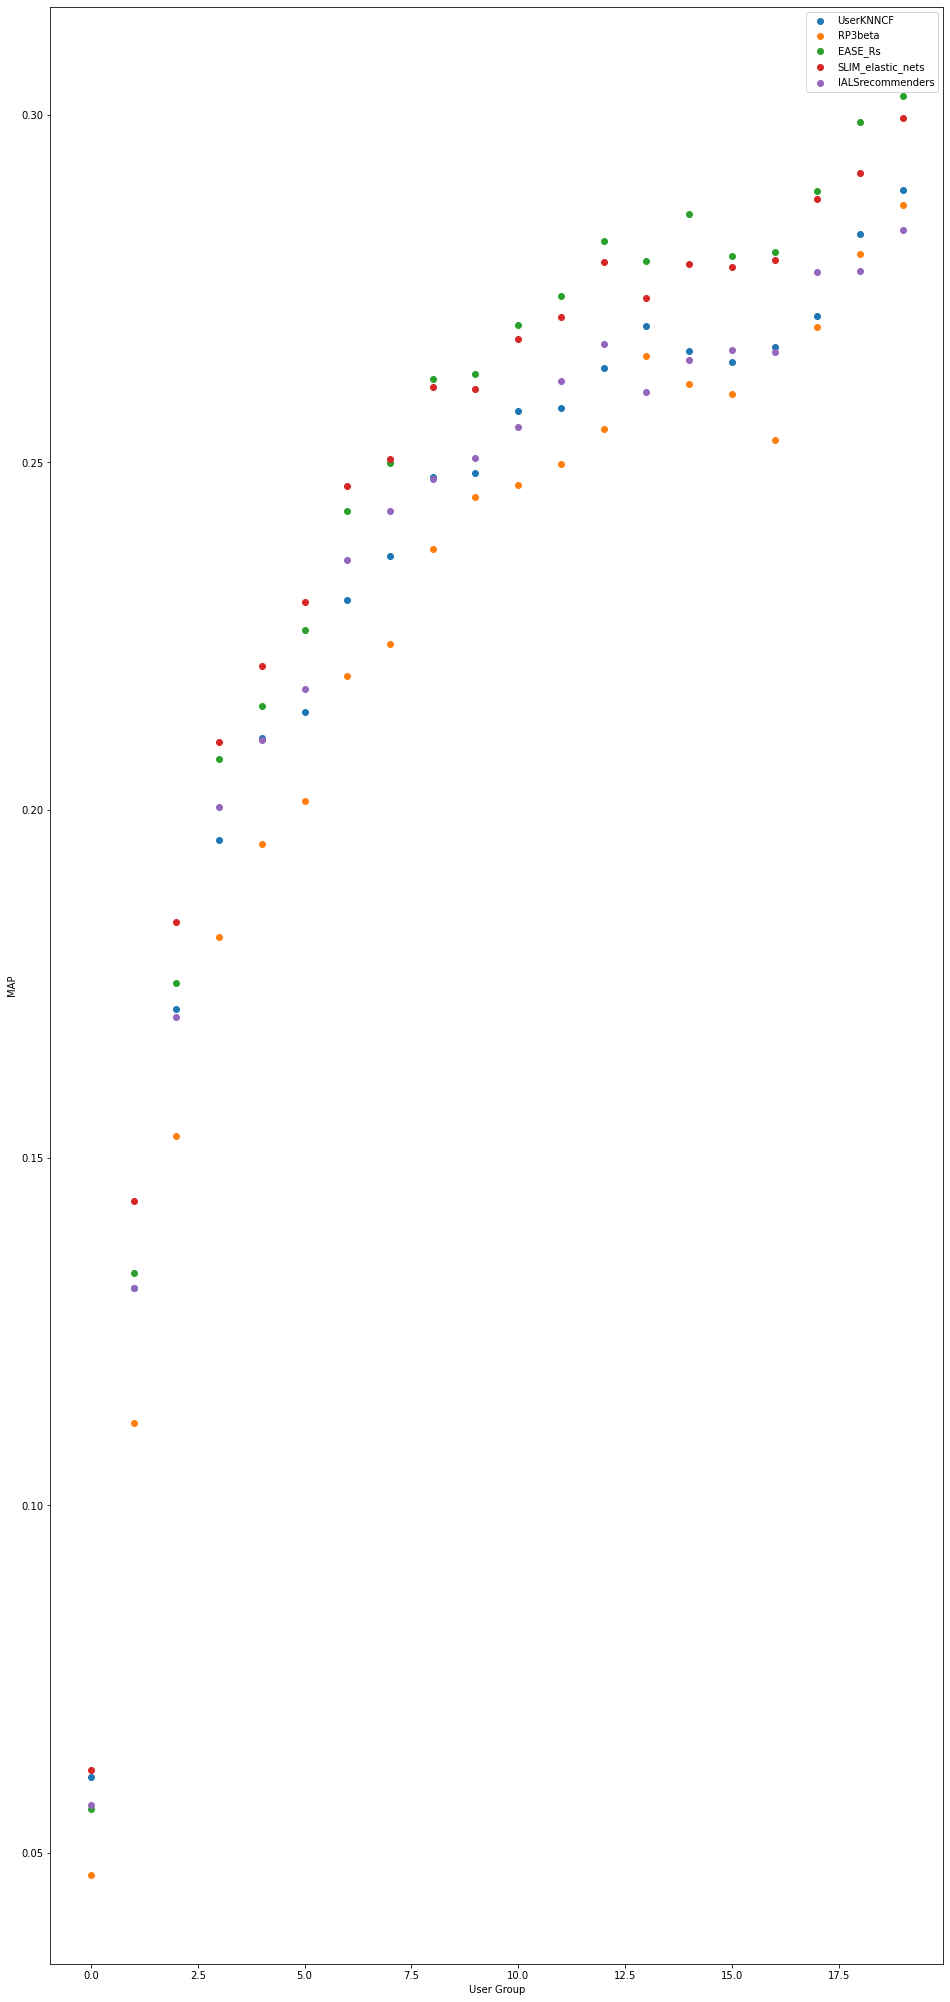

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline  
recommender_object_dict = {#"stacekdUSER": stackeduserKNNCFs[0],
                           "UserKNNCF": userKNNCFs,
                           "RP3beta": RP3betas,
                           "EASE_Rs": EASE_Rs,
                           "SLIM_elastic_nets": SLIM_elastic_nets,
                           #"multi slim": multiSLIMs,
                           "IALSrecommenders": IALSrecommenders,
                           #"best": best,
                           }

_ = plt.figure(figsize=(16, 36))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [34]:
score_total=[]
profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
sorted_users = np.argsort(profile_length)
block_size = int(len(profile_length)*0.05)
cutoff = 10
MAP_recommender_per_group = {}
for group_id in range(0, 20):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]

    group_id="warm"
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    
    evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
    scores = []
    score=0
    for i in range(5):
        final_rec = best(URMs_train[i],userKNNCFs[i],IALSrecommenders[i],EASE_Rs[i],SLIM_elastic_nets[i])
        final_rec.fit(w1=0.7769345987358156,w2=0.5744832112927918,w3=3.545907364652354,w4=3.7631372828929885)
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(final_rec)
        score = score + result.MAP
    score=score/5
    print("best"),print(score) 

Group warm, #users in group 682, average p.len 40.71, median 41.5, min 9, max 68
EvaluatorHoldout: Ignoring 13642 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 678 (100.0%) in 20.84 sec. Users per second: 33
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 677 (100.0%) in 20.32 sec. Users per second: 33
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 673 (100.0%) in 20.45 sec. Users per second: 33
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 675 (100.0%) in 20.81 sec. Users 

In [ ]:
from Recommenders.BaseSimilarityMatrixRecommender import *
class hybridization(BaseRecommender):
    def __init__(self, URM,recommender0,recommender1,recommender2,recommender3,recommender4,recommender5,
                  exclude_seen=True,norm_scores=True):  

        super().__init__(URM, exclude_seen)
        self.URM=URM
        self.norm_scores=norm_scores
        self.normalize = None
        self.weights = {}
        self.weight_vec = None
        self.ratings = None
        self.rating_masks = None
        self.recommender0 = recommender0
        self.recommender1 = recommender1
        self.recommender2 = recommender2
        self.recommender3 = recommender3
        self.recommender4 = recommender4
        self.recommender5 = recommender5
        self.low_data_rec_idxs = None
        self.threshold = 3

    def fit(self,TopPop_weight=0,UCF_weight=0,IALS_weight=0,EASE_R_weight=0,SLIM_elastic_net_weight=0, RP3beta_weight=0, 
            normalize=True, threshold=0):
        self.w0= UCF_weight
        self.w1= IALS_weight
        self.w2= EASE_R_weight
        self.w3= SLIM_elastic_net_weight
        self.w4= RP3beta_weight
        self.w5= TopPop_weight
        self.normalize=normalize        
    
    def _compute_item_score(self, user_id_array, items_to_compute=None):
        item_scores0 = self.recommender0._compute_item_score(user_id_array, items_to_compute)           
        item_scores1 = self.recommender1._compute_item_score(user_id_array, items_to_compute)
        item_scores2 = self.recommender2._compute_item_score(user_id_array, items_to_compute)
        item_scores3 = self.recommender3._compute_item_score(user_id_array, items_to_compute)
        item_scores4 = self.recommender4._compute_item_score(user_id_array, items_to_compute)
        item_scores5 = self.recommender5._compute_item_score(user_id_array, items_to_compute)
        
        if self.normalize:
            mean0 = np.mean(item_scores0)
            mean1 = np.mean(item_scores1)
            mean2 = np.mean(item_scores2)
            mean3 = np.mean(item_scores3)
            mean4 = np.mean(item_scores4)
            mean5 = np.mean(item_scores5)
            std0 = np.std(item_scores0)
            std1 = np.std(item_scores1)
            std2 = np.std(item_scores2)
            std3 = np.std(item_scores3)
            std4 = np.std(item_scores4)
            std5 = np.std(item_scores5)
            item_scores0 = (item_scores0 - mean0) / std0
            item_scores1 = (item_scores1 - mean1) / std1
            item_scores2 = (item_scores2 - mean2) / std2
            item_scores3 = (item_scores3 - mean3) / std3
            item_scores4 = (item_scores4 - mean4) / std4
            item_scores5 = (item_scores5 - mean5) / std5
        
        
        item_scores = (item_scores0 * self.w0) +(item_scores1 * self.w1) + (item_scores2 * self.w2) 
        + (item_scores3 * self.w3) + (item_scores4 * self.w4) + (item_scores5 * self.w5) 
        
        return item_scores
    
    def recommend(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        
        #userknn + top_pop
        borda_rank = []
        final_rec = []
        final_weight = []
        recs0 = self.recommender0.recommend(user_id)[:10]
        recs1 = self.recommender1.recommend(user_id)[:10]
        recs2 = self.recommender2.recommend(user_id)[:10]
        recs3 = self.recommender3.recommend(user_id)[:10]
        recs4 = self.recommender4.recommend(user_id)[:10]
        recs5 = self.recommender5.recommend(user_id)[:10]
        
        for i in range(0,10):
            borda_rank.append([recs0[i],(10-i)*self.w0])
            borda_rank.append([recs1[i],(10-i)*self.w1])
            borda_rank.append([recs2[i],(10-i)*self.w2])
            borda_rank.append([recs3[i],(10-i)*self.w3])
            borda_rank.append([recs4[i],(10-i)*self.w4])
            borda_rank.append([recs5[i],(10-i)*self.w5])
            
        for i in borda_rank:
            is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
            if not is_in:
                final_rec.append(i[0])
                final_weight.append(i[1])
            else:
                final_weight[final_rec.index(i[0])] += i[1]

        recs = []
        rec = 0
        maxs = -1
        for i in range (0,10):
            for j in range(0,len(final_weight)):
                if final_weight[j] > maxs:
                    maxs = final_weight[j]
                    rec = final_rec[j]
            final_weight.remove(maxs)
            final_rec.remove(rec)
            maxs=-1
            recs.append(rec)
        return recs

In [ ]:
from Recommenders.BaseSimilarityMatrixRecommender import *
class hybridization_warm(BaseRecommender):
    def __init__(self, URM,recommender0,recommender1,exclude_seen=True,norm_scores=True):  
        super().__init__(URM, exclude_seen)
        self.URM=URM
        self.norm_scores=norm_scores
        self.normalize = None
        self.weights = {}
        self.weight_vec = None
        self.ratings = None
        self.rating_masks = None
        self.recommender0 = recommender0
        self.recommender1 = recommender1
        self.low_data_rec_idxs = None
        self.threshold = 3

    def fit(self,EASE_R_weight=0,SLIM_elastic_net_weight=0, 
            normalize=True, threshold=0):
        self.w0= EASE_R_weight
        self.w1= SLIM_elastic_net_weight
        self.normalize=normalize        
    
    def _compute_item_score(self, user_id_array, items_to_compute=None):
        item_scores0 = self.recommender0._compute_item_score(user_id_array, items_to_compute)           
        item_scores1 = self.recommender1._compute_item_score(user_id_array, items_to_compute)
        
        if self.normalize:
            mean0 = np.mean(item_scores0)
            mean1 = np.mean(item_scores1)
            std0 = np.std(item_scores0)
            std1 = np.std(item_scores1)
            item_scores0 = (item_scores0 - mean0) / std0
            item_scores1 = (item_scores1 - mean1) / std1
        
        item_scores = (item_scores0 * self.w0) +(item_scores1 * self.w1) 
        
        return item_scores


In [ ]:
from Recommenders.BaseRecommender import BaseRecommender
class mergingRec(BaseItemSimilarityMatrixRecommender):

    RECOMMENDER_NAME = "MergeRecommenders"

    def __init__(self,URM,recommender0=None,recommender1=None,recommender2=None,recommender3=None,recommender4=None,recommender5=None,
                 w0=0,w1=0,w2=0,w3=0,w4=0,w5=0,w6=0,w7=0,exclude_seen=True):
       super().__init__(URM, exclude_seen)     
       self.exclude_seen = True
       self.recommender0 = recommender0
       self.recommender1 = recommender1
       self.recommender2 = recommender2
       self.recommender3 = recommender3
       self.recommender4 = recommender4
       self.recommender5 = recommender5
       self.w0=w0
       self.w1=w1
       self.w2=w2
       self.w3=w3
       self.w4=w4
       self.w5=w5
       self.w6=w6
       self.w7=w7
    def recommend(self, user_id_array,
                  exclude_seen=True,remove_seen_flag=True,cutoff=10,remove_top_pop_flag=True,
                  return_scores=True,remove_custom_items_flag=True):
        recommendations={}
        #if not type(user_id_array)==np.array
        relevant_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
        if len(relevant_items) > 563:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:20]
            recs2 = self.recommender2.recommend(user_id)[:20]

            for i in range(0,10):
                borda_rank.append([recs1[i],(20-i)*self.w1])
                borda_rank.append([recs2[i],(20-i)*self.w2])

            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            return recs
        if len(relevant_items) > 563:
            borda_rank = []
            final_rec = []
            final_weight = []
            recs1 = self.recommender1.recommend(user_id)[:20]
            recs2 = self.recommender2.recommend(user_id)[:20]

            for i in range(0,10):
                borda_rank.append([recs1[i],(20-i)*self.w1])
                borda_rank.append([recs2[i],(20-i)*self.w2])

            for i in borda_rank:
                is_in = (len(list(filter (lambda x : x == i[0], final_rec))) > 0)    
                if not is_in:
                    final_rec.append(i[0])
                    final_weight.append(i[1])
                else:
                    final_weight[final_rec.index(i[0])] += i[1]

            recs = []
            rec = 0
            maxs = -1
            for i in range (0,10):
                for j in range(0,len(final_weight)):
                    if final_weight[j] > maxs:
                        maxs = final_weight[j]
                        rec = final_rec[j]
                final_weight.remove(maxs)
                final_rec.remove(rec)
                maxs=-1
                recs.append(rec)
            return recs
        
        top
        return recs
        

In [ ]:
from Recommenders.PredefinedListRecommender import *

In [33]:
def eval_group(int1=None,int2=None,name="?group?"):
    score_total=[]
    profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
    sorted_users = np.argsort(profile_length)
    block_size = int(len(profile_length)*0.1)
    cutoff = 10
    MAP_recommender_per_group = {}

    profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
    sorted_users = np.argsort(profile_length)

    if int2==None:
        users_in_group = sorted_users[int1:]
    elif int1==None:
        users_in_group = sorted_users[:int2]
    else:
        users_in_group = sorted_users[int1:int2]
        
    users_in_group_p_len = profile_length[users_in_group]
    group_id=name
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    score=0
    for i in range(5):
        top_pop=TopPop(URMs_train[i])
        top_pop.fit()
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(top_pop)
        score = score + result.MAP
    score=score/5
    print("topPop"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(EASE_Rs[i])
        score = score + result.MAP
    score=score/5
    print("EASE_R"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(userKNNCFs[i])
        score = score + result.MAP
    score=score/5
    print("userKNNCF"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(stackeduserKNNCFs[i])
        score = score + result.MAP
    score=score/5
    print("stackeduserKNNCF"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(RP3betas[i])
        score = score + result.MAP
    score=score/5
    print("RP3beta"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(IALSrecommenders[i])
        score = score + result.MAP
    score=score/5
    print("IALSrecommenders"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(SLIM_elastic_nets[i])
        score = score + result.MAP
    score=score/5
    print("SLIM_elastic_nets"),print(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(multiSLIMs[i])
        score = score + result.MAP
    score=score/5
    print("multi_slim"),print(score)

In [ ]:
eval_group(int1=10920,name="warm")#ease_r +slim      rp3beta+userknn+ials

In [ ]:
eval_group(int1=2745,int2=10920,name="mid")# ease_R + slim      userknn+ials

In [ ]:
eval_group(int1=80,int2=2745,name="cold")#slim     ease_R + userknn  +  ials

In [40]:
eval_group(int2=143,name="new")#userknn + top_pop

Group new, #users in group 143, average p.len 16.36, median 17.0, min 9, max 23
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13507 Users
EvaluatorHoldout: Processed 139 (100.0%) in 0.75 sec. Users per second: 185
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13507 Users
EvaluatorHoldout: Processed 138 (100.0%) in 0.74 sec. Users per second: 188
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13507 Users
EvaluatorHoldout: Processed 135 (100.0%) in 0.77 sec. Users per second: 175
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13507 Users
EvaluatorHoldout: Processed 136 (100.0%) in 0.73 sec. Users per second: 186
EvaluatorHoldout: Ignoring 13642 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignorin

In [ ]:
score_total=[]
profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
sorted_users = np.argsort(profile_length)
block_size = int(len(profile_length)*0.05)
cutoff = 10
MAP_recommender_per_group = {}
for group_id in range(0, 20):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]

    group_id="warm"
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]


    evaluator_validationgg = EvaluatorHoldout(URMs_test[0], cutoff_list=[cutoff], ignore_users=users_not_in_group)
    scores = []
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(EASE_Rs[i])
        score = score + result.MAP
    score=score/5
    #print("userKNNCF"),print(score) 
    scores.append(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(userKNNCFs[i])
        score = score + result.MAP
    score=score/5
    #print("userKNNCF"),print(score)
    scores.append(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(RP3betas[i])
        score = score + result.MAP
    score=score/5
    #print("RP3beta"),print(score)
    scores.append(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(IALSrecommenders[i])
        score = score + result.MAP
    score=score/5
    #print("IALSrecommenders"),print(score)
    scores.append(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(SLIM_elastic_nets[i])
        score = score + result.MAP
    score=score/5
    #print("SLIM_elastic_nets"),print(score)
    scores.append(score)
    score=0
    for i in range(5):
        evaluator_validationgg = EvaluatorHoldout(URMs_test[i], cutoff_list=[cutoff], ignore_users=users_not_in_group)
        result,_ = evaluator_validationgg.evaluateRecommender(multiSLIMs[i])
        score = score + result.MAP
    score=score/5
    scores.append(score)
    score_total.append(scores)
print(score_total)

In [ ]:
for i in range(10):##0-17;18-179;180-563;564-2191
    print(score_total[i])#0__1;2__7;8__9 

In [44]:
profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
sorted_users = np.argsort(profile_length)

users_in_group = sorted_users[155:2745]

users_in_group_p_len = profile_length[users_in_group]
group_id="asd"
print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
    group_id, 
    users_in_group.shape[0],
    users_in_group_p_len.mean(),
    np.median(users_in_group_p_len),
    users_in_group_p_len.min(),
    users_in_group_p_len.max()))


users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group = sorted_users[users_not_in_group_flag]

Group asd, #users in group 2590, average p.len 112.97, median 116.5, min 24, max 179


In [ ]:
userKNNCFs = []
stackeduserKNNCFs = []
RP3betas = []
IALSrecommenders = []
SLIM_elastic_nets = []
EASE_Rs = []
URMs_train = []
URMs_test = []
multiSLIMs=[]
for i in range(5):
    URMs_train.append(sps.load_npz(str(i)+"URM_train_csr.npz"))
    URMs_test.append(sps.load_npz(str(i)+"URM_test_csr.npz"))
    
    
    stackeduserKNNCFs.append(UserKNNCFRecommender(URMs_train[i],ICM))
    userKNNCFs.append(UserKNNCFRecommender(URMs_train[i]))
    RP3betas.append(RP3betaRecommender(URMs_train[i]))
    IALSrecommenders.append(IALSRecommender(URMs_train[i]))
    SLIM_elastic_nets.append(SLIMElasticNetRecommender(URMs_train[i]))
    EASE_Rs.append(EASE_R_Recommender(URMs_train[i], ICM))
    multiSLIMs.append(MultiThreadSLIM_SLIMElasticNetRecommender(URMs_train[i]))
    
    stackeduserKNNCFs[i].load_model("saved_models/","stackeduserKNNCF"+str(i))
    userKNNCFs[i].load_model("saved_models/","userKNNCF_"+str(i))
    RP3betas[i].load_model("saved_models/","RP3beta_"+str(i))
    IALSrecommenders[i].load_model("saved_models/","IALSrecommender_"+str(i))
    EASE_Rs[i].load_model("saved_models/","stackedEASE_R"+str(i))#stacked
    SLIM_elastic_nets[i].load_model("saved_models/","SLIM_elastic_net_"+str(i))
    multiSLIMs[i].load_model("saved_models/","multi_slim_"+str(i))


In [ ]:
np.argsort(userKNNCFs[0]._compute_item_score(1))


In [71]:
top_pops=[]
for i in range(5):
    top_pop=TopPop(URMs_train[i])
    top_pop.fit()
    top_pops.append(top_pop)
    
recslist=[]
recslist.append(top_pops)
recslist.append(userKNNCFs)
recslist.append(stackeduserKNNCFs)
recslist.append(IALSrecommenders)
recslist.append(EASE_Rs)
recslist.append(SLIM_elastic_nets)

In [ ]:
from HyperparameterTuning.optimize_parameters import *
optimize_parameters_kfold(URMs_train,ICM,recslist,best,n_calls=100,seed=42)


In [45]:
profile_length = np.ediff1d(sps.csr_matrix(URM).indptr)
sorted_users = np.argsort(profile_length)

users_in_group = sorted_users[:155]

users_in_group_p_len = profile_length[users_in_group]
group_id="warm"
print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
    group_id, 
    users_in_group.shape[0],
    users_in_group_p_len.mean(),
    np.median(users_in_group_p_len),
    users_in_group_p_len.min(),
    users_in_group_p_len.max()))


users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
users_not_in_group1 = sorted_users[users_not_in_group_flag]

Group warm, #users in group 155, average p.len 16.90, median 17.0, min 9, max 24


In [ ]:
score=0
for j in range(0,5):
    hybrid = hybridization4(URMs_train[j],userKNNCFs[j],IALSrecommenders[j],
                           EASE_Rs[j],SLIM_elastic_nets[j],RP3betas[j])
    hybrid.fit(UCF_weight= 0, IALS_weight= 0, 
           EASE_R_weight= 6, SLIM_elastic_net_weight=6, 
           RP3beta_weight= 0,normalize= True)
    evaluator_validation = EvaluatorHoldout(URMs_test[j], cutoff_list=[10],ignore_users=users_not_in_group4)
    result,_=evaluator_validation.evaluateRecommender(hybrid)
    print(result.MAP),print(result.MAP_MIN_DEN)
    score = score + result.MAP
score=score/5
print(score)

In [126]:
import random
bestscore=0
for j in range(500):
    print(j)
    w1c=random.randint(0,50)/10
    w2c=random.randint(0,50)/10
    w3c=random.randint(0,100)/10
    w4c=random.randint(0,100)/10
    score=0
    for i in range(5):
        final_rec = best(URMs_train[i],top_pops[i],userKNNCFs[i],stackeduserKNNCFs[i],IALSrecommenders[i],
                                       EASE_Rs[i],SLIM_elastic_nets[i])
        final_rec.fit(w1= 1.5990064734053968, w2= 0.6748196218391801, w3= 3.5520055696782658, w4= 2.565222120722938, 
         w1cold= 4.1, w2cold= 2.1, w3cold= 4, w4cold= 7.3, 
         w1mid= 0.7769345987358156, w2mid= 0.5744832112927918, w3mid= 3.445907364652354, w4mid= 3.7631372828929885)
        evaluator_validation = EvaluatorHoldout(URMs_test[i], cutoff_list=[10])
        result,_=evaluator_validation.evaluateRecommender(final_rec)
        #print(result.MAP)
        score = score + result.MAP
    score=score/5
    print(score),print(w1c),print(w2c),print(w3c),print(w4c)
    

0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13646 (100.0%) in 2.14 min. Users per second: 106
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13645 (100.0%) in 2.24 min. Users per second: 102
EvaluatorHoldout: Ignoring 13641 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13641 (100.0%) in 2.13 min. Users per second: 107
EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13643 (100.0%) in 2.05 min. Users per second: 111
EvaluatorHoldout: Ignoring 13642 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 13642 (100.0%) in 2.07 min. Users per second: 110
cutoff
10    0.249494
Name: MAP, dtype: object
2.7
3.7
7.7
5.7
1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Pro

KeyboardInterrupt: 

In [ ]:
import random
bestscore=0
top_pops=[]
for i in range(5):
    top_pop=TopPop(URMs_train[i])
    top_pop.fit()
    top_pops.append(top_pop)
for i in range(500):
    print(i)
    w0=random.randint(0,10000)/1000
    w1=random.randint(0,10000)/1000
    w2=random.randint(0,10000)/1000
    w3=random.randint(0,10000)/1000
    w4=random.randint(0,10000)/1000
    w5=random.randint(0,10000)/1000
    w6=random.randint(0,10000)/1000
    w7=random.randint(0,10000)/1000
    w8=random.randint(0,10000)/1000
    w9=random.randint(0,10000)/1000
    w10=random.randint(0,10000)/1000
    w11=random.randint(0,10000)/1000
    w12=random.randint(0,10000)/1000
    w13=random.randint(0,10000)/1000
    w14=random.randint(0,10000)/1000
    
    score=0
    for j in range(0,5):
        test_hyb = new_hybridization(URMs_train[j],top_pops[j],userKNNCFs[j],IALSrecommenders[j],RP3betas[j],
                                   EASE_Rs[j],SLIM_elastic_nets[j])
        test_hyb.fit(new_top_pop=w0,new_user_knn_cf=w1,UCF_cold=w2,
                 IALS_cold= w3,EASE_R_cold=w4,SLIM_elastic_net_cold=w5,
                 UCF_mid= w6,IALS_mid=w7,EASE_R_mid=w8,
                 SLIM_elastic_net_mid= w9,UCF_warm=w10,IALS_warm=w11,
                 EASE_R_warm=w12,SLIM_elastic_net_warm=w13,RP3beta_warm=w14)
        evaluator_validation = EvaluatorHoldout(URMs_test[j], cutoff_list=[10])
        result,_=evaluator_validation.evaluateRecommender(test_hyb)
        print(result.MAP)
        score = score + result.MAP
    score=score/5
    print(score)
    if score.get(10)>bestscore:
        bestscore=score.get(10)
        bestvalue=[w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14]
        print(bestvalue)

In [ ]:
"new_top_pop":Categorical([10]),#Real(0,10),
    "new_user_knn_cf":Categorical([10]),#Real(0,10),
    "UCF_cold":Real(0,10),
    "IALS_cold":Real(0,10),
    "EASE_R_cold":Real(0,10),
    "SLIM_elastic_net_cold":Real(0,10),
    "UCF_mid":Real(0,10),
    "IALS_mid":Real(0,10),
    "EASE_R_mid":Real(0,10),
    "SLIM_elastic_net_mid":Real(0,10),
    "EASE_R_warm":Real(0,10),
    "SLIM_elastic_net_warm":Real(0,10),
    "UCF_warm":Real(0,10),
    "IALS_warm":Real(0,10),
    "RP3beta_warm":Real(0,10),
    "normalize":Categorical([True]),

In [ ]:
cutoff = 20
user_recommendations_items = []
user_recommendations_user_id = []

for n_user in range(URM.shape[0]):
    
    recommendations = final_rec.recommend(n_user, cutoff = 20)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([n_user]*len(recommendations))
    
user_profile_len = np.ediff1d(URM_train.indptr)
user_profile_len_list = []

target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    user_profile_len_list.append(user_profile_len[user_id])
    
train_dataframe['user_profile_len'] = pd.Series(user_profile_len_list, index=train_dataframe.index)
train_dataframe



# Submission part

train su tutto il dataset

In [ ]:
URM = sps.csr_matrix((URM.interaction,(URM.userID,URM.itemID)))

In [ ]:
stacked_URM = sps.vstack([URM, ICM.T])
stacked_URM = sps.csr_matrix(stacked_URM)

In [ ]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender







In [90]:
fullmulti_slim = MultiThreadSLIM_SLIMElasticNetRecommender(URM)
fullmulti_slim.fit(topK =148, l1_ratio =0.006715186447524162, alpha =0.12556056594602652)
fullmulti_slim.save_model("saved_models/","fullmultiSLIM")

100%|█████████▉| 18032/18059 [16:30<00:01, 23.26it/s]

SLIMElasticNetRecommender: Saving model in file 'saved_models/fullmultiSLIM'
SLIMElasticNetRecommender: Saving complete


In [11]:
fullEASE_R = EASE_R_Recommender(URM, ICM)
fullEASE_R.fit(topK=None, l2_norm = 6849.353601137822, normalize_matrix = False,alpha= 15.834009463721085, stacked= True)
fullstackeduserKNNCF = UserKNNCFRecommender(URM,ICM)
fullstackeduserKNNCF.fit(topK= 421, shrink= 92.71432078633666, normalize= False, similarity ='jaccard', 
                         feature_weighting ='TF-IDF', stacked =True, alpha= 7.470823573622052)


EASE_R_Recommender: Fitting model... 
Similarity column 18059 (100.0%), 654.61 column/sec. Elapsed time 27.59 sec
EASE_R_Recommender: Fitting model... done in 3.32 min
Similarity column 13996 (100.0%), 347.56 column/sec. Elapsed time 40.27 sec


In [10]:
fulluserKNNCF = UserKNNCFRecommender(URM)
fullRP3beta = RP3betaRecommender(URM)
fullIALSrecommender = IALSRecommender(URM)
fullSLIM_elastic_net = SLIMElasticNetRecommender(URM)
#fullEASE_R = EASE_R_Recommender(URM, ICM)
#fullstackedEASE_R = EASE_R_Recommender(URM, ICM)

#fullEASE_R.load_model("saved_models/","fullEASE_R")
fullRP3beta.load_model("saved_models/","fullRP3beta")
fullSLIM_elastic_net.load_model("saved_models/","fullSLIM_elastic_net")
fullIALSrecommender.load_model("saved_models/","fullIALSrecommender")
fulluserKNNCF.load_model("saved_models/","fulluserKNNCF")
#fullstackedEASE_R.save_model("saved_models/","fullstackedEASE_R")

RP3betaRecommender: Loading model from file 'saved_models/fullRP3beta'
RP3betaRecommender: Loading complete
SLIMElasticNetRecommender: Loading model from file 'saved_models/fullSLIM_elastic_net'
SLIMElasticNetRecommender: Loading complete
IALSRecommender: Loading model from file 'saved_models/fullIALSrecommender'
IALSRecommender: Loading complete
UserKNNCFRecommender: Loading model from file 'saved_models/fulluserKNNCF'
UserKNNCFRecommender: Loading complete


In [ ]:
hybrid = hybridization(URM,fulluserKNNCF,fullIALSrecommender,
                       fullEASE_R,fullSLIM_elastic_net,fullRP3beta)
hybrid.fit(UCF_weight= 0.5, IALS_weight= 0.75, 
           EASE_R_weight= 4, SLIM_elastic_net_weight= 4, 
           RP3beta_weight=0.5,normalize= True)

In [ ]:
test_hyb = new_hybridization(URMs_train[i],top_pop0,userKNNCFs[i],IALSrecommenders[i],RP3betas[i],
                                   EASE_Rs[i],multiSLIMs[i])
test_hyb.fit(new_top_pop=10,new_user_knn_cf=10,UCF_cold=5,
                 IALS_cold= 0,EASE_R_cold=0,SLIM_elastic_net_cold= 6.158502697947562,
                 UCF_mid= 3,IALS_mid=2.2345226864962315,EASE_R_mid=6.109970217403359,
                 SLIM_elastic_net_mid= 9.909610018878162,UCF_warm=0.979219031611222,IALS_warm=0.7639242560499209,
                 EASE_R_warm=3.4262061750333936,SLIM_elastic_net_warm=3.4262061750333936,RP3beta_warm=0)

In [ ]:
import csv
with open('alg_sample_submission.csv', 'w',newline='') as f:
    writer = csv.writer(f, delimiter=" ")
    writer.writerow(['user_id,item_list'])
    test_hyb = new_hybridization(URMs_train[i],top_pop0,userKNNCFs[i],IALSrecommenders[i],RP3betas[i],
                                   EASE_Rs[i],multiSLIMs[i])
    test_hyb.fit(new_top_pop=10,new_user_knn_cf=10,UCF_cold=5,
                 IALS_cold= 0,EASE_R_cold=0,SLIM_elastic_net_cold= 6.158502697947562,
                 UCF_mid= 3,IALS_mid=2.2345226864962315,EASE_R_mid=6.109970217403359,
                 SLIM_elastic_net_mid= 9.909610018878162,UCF_warm=0.979219031611222,IALS_warm=0.7639242560499209,
                 EASE_R_warm=3.4262061750333936,SLIM_elastic_net_warm=3.4262061750333936,RP3beta_warm=0)
    writer.writerow([(str(user_id) + ','), *(np.array(hybrid.recommend_sub(0)[:10]))])
    print([(str(user_id) + ','), *(np.array(hybrid.recommend_sub(0)[:10]))])

In [ ]:
import numpy
import csv

fulltop_pop = TopPop(URM)
fulltop_pop.fit()
with open('alg_sample_submission.csv', 'w',newline='') as f:
    writer = csv.writer(f, delimiter=" ")
    writer.writerow(['user_id,item_list'])
    for user_id in data_target_users_test['userID']:
        final_rec = best(URM,fulltop_pop,fulluserKNNCF,fullstackeduserKNNCF,fullIALSrecommender,fullEASE_R,fullSLIM_elastic_net,fullRP3beta)
        final_rec.fit(w1=  0.013059189410321583, w2= 1.247868316413647, w3= 3.8459515717040627, w4= 0.9593742978140043,w5=9.486624813452256 ,
             w1cold= 7.371168409713473, w2cold=  9.743528125842841, w3cold= 5.489873036691385, w4cold= 0.15734772150403645,w5cold=9.09492719811822, 
             w1mid= 3.4160881151114, w2mid=  0.04709488511906224, w3mid= 9.221832671850352, w4mid= 9.49397791936225,w5mid= 3.2934610527054557)
        writer.writerow([(str(user_id) + ','), *(np.array(final_rec.recommend_sub(user_id)[:10]))])

In [ ]:
import numpy
import csv

with open('alg_sample_submission.csv', 'w',newline='') as f:
    writer = csv.writer(f, delimiter=" ")
    writer.writerow(['user_id,item_list'])
    for user_id in data_target_users_test['userID']:
        relevant_items = URM.indices[URM.indptr[user_id]:URM.indptr[user_id + 1]]
        if len(relevant_items)<17:
            hybrid = hybridization(URM,fulluserKNNCF,fullIALSrecommender,
                       fullEASE_R,fullSLIM_elastic_net,fullRP3beta,fulltop_pop)
            hybrid.fit(TopPop_weight=1,UCF_weight= 0, IALS_weight= 0, 
               EASE_R_weight= 0, SLIM_elastic_net_weight= 0, 
               RP3beta_weight=1,normalize= True)
            writer.writerow([(str(user_id) + ','), *(np.array(hybrid.recommend(user_id)[:10]))])
        elif len(relevant_items)<17:
            hybrid = hybridization(URM,fulluserKNNCF,fullIALSrecommender,
                       fullEASE_R,fullSLIM_elastic_net,fullRP3beta,fulltop_pop)
            hybrid.fit(TopPop_weight=0,UCF_weight= 1, IALS_weight= 1, 
               EASE_R_weight= 1.5, SLIM_elastic_net_weight= 3.5, 
               RP3beta_weight=0,normalize= True)
            writer.writerow([(str(user_id) + ','), *(np.array(hybrid.recommend(user_id)[:10]))])
        elif len(relevant_items)<17:
            hybrid = hybridization(URM,fulluserKNNCF,fullIALSrecommender,
                       fullEASE_R,fullSLIM_elastic_net,fullRP3beta,fulltop_pop)
            hybrid.fit(TopPop_weight=0,UCF_weight= 0.75, IALS_weight= 0.75, 
               EASE_R_weight=3.5, SLIM_elastic_net_weight= 3.5, 
               RP3beta_weight=0,normalize= True)
            writer.writerow([(str(user_id) + ','), *(np.array(hybrid.recommend(user_id)[:10]))])
        else:
            hybrid = hybridization(URM,fulluserKNNCF,fullIALSrecommender,
                       fullEASE_R,fullSLIM_elastic_net,fullRP3beta,fulltop_pop)
            hybrid.fit(TopPop_weight=0,UCF_weight= 0.75, IALS_weight= 0.5, 
               EASE_R_weight= 3.5, SLIM_elastic_net_weight= 3.5, 
               RP3beta_weight=0.5,normalize= True)
            writer.writerow([(str(user_id) + ','), *(np.array(hybrid.recommend(user_id)[:10]))])
        